In [1]:
!pip -q install yellowbrick==1.3

!pip -q install kneed
!pip -q install factor_analyzer
!pip -q install seaborn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [226]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from yellowbrick.features import PCA as YBPCA
from kneed import KneeLocator
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
#import plotly.express as px

In [347]:
# factor analysis
def evaluate_pcs(num_of_pcs,data):
    def encode_vals(x): #helper functions to suppress loading less than 0.7 
    #a gradual process to lead to this function
    # if x<=-0.5, we drop the variable
        if x <= -0.5 or x >= 0.5: #Adjust the threshold value 
            return x
        else:
            return("")    
    f = FactorAnalyzer(n_factors=num_of_pcs, method = 'principal',rotation='varimax') #Conduct PCA + varimax rotation to extract latent factors 
    f.fit(data)
    loadings = pd.DataFrame(f.loadings_).set_index(data.columns)
    loadings = loadings.applymap(encode_vals)
    loadingcols= list(loadings.columns)
    newcols = {}
    for i in loadingcols:
        newcols[i] = "PC" + str(i+1)
    loadings.rename(columns = newcols,inplace=True)
    
    
    df_pca = f.transform(data)
    return loadings , df_pca

# The following function generates the rotation matrix. Recall that we use
# this matrix to determine if the PCs generated are easily understandable and appropriate.
# The argument "num_of_pcs" specifies, the number of PCs we wish to generate.

In [227]:
bike = pd.read_csv('bike_agg_with_season_no.csv')
bike.head()

,Unnamed: 0,date,rent_count,temperature,rainfall,snowfall,season,holiday,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity,season_no
0,1,2017-12-01,9539,-2.454167,0.0,0,Spring,No Holiday,1.537500,18707.500000,0.248750,-13.545833,45.875000,1
1,2,2017-12-02,8523,1.325000,0.0,0,Spring,No Holiday,1.712500,14710.833333,0.263750,-5.716667,61.958333,1
2,3,2017-12-03,7222,4.875000,4.0,0,Spring,No Holiday,1.612500,4557.500000,0.125417,1.883333,81.541667,1
3,4,2017-12-04,8729,-0.304167,0.1,0,Spring,No Holiday,3.450000,13628.333333,0.282917,-9.925000,52.500000,1
4,5,2017-12-05,8307,-4.458333,0.0,0,Spring,No Holiday,1.108333,19594.583333,0.035833,-17.425000,36.416667,1


# 1st Run: Drop Snowfall
Snowfall will cause a calculation error for p-value and kmo value.

In [331]:
# As PCA is a unsupervised learning algorithm, we will drop the Season column
# We will drop datetime and date as well since they are not numeric
bike2 = bike.copy()
bike2.drop(columns = ['date','holiday','rent_count','season_no','season','snowfall'],inplace=True)
bike2.head()

,Unnamed: 0,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
0,1,-2.454167,0.0,1.537500,18707.500000,0.248750,-13.545833,45.875000
1,2,1.325000,0.0,1.712500,14710.833333,0.263750,-5.716667,61.958333
2,3,4.875000,4.0,1.612500,4557.500000,0.125417,1.883333,81.541667
3,4,-0.304167,0.1,3.450000,13628.333333,0.282917,-9.925000,52.500000
4,5,-4.458333,0.0,1.108333,19594.583333,0.035833,-17.425000,36.416667


In [332]:
# remvove first column
bike3 = bike2.iloc[: , 1:]
bike3.head()

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
0,-2.454167,0.0,1.537500,18707.500000,0.248750,-13.545833,45.875000
1,1.325000,0.0,1.712500,14710.833333,0.263750,-5.716667,61.958333
2,4.875000,4.0,1.612500,4557.500000,0.125417,1.883333,81.541667
3,-0.304167,0.1,3.450000,13628.333333,0.282917,-9.925000,52.500000
4,-4.458333,0.0,1.108333,19594.583333,0.035833,-17.425000,36.416667


In [333]:
list(bike3.columns)

['temperature',
 'rainfall',
 'wind_speed',
 'visibility',
 'solar_radiation',
 'dewpoint_temp',
 'humidity']

In [334]:
bike3.describe()

# we see each attributes have different ranges

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,12.775844,3.575921,1.726148,14340.136574,0.567732,3.954165,58.166271
std,11.718397,11.789868,0.597281,4911.560587,0.316125,12.992939,14.865518
min,-14.737500,0.000000,0.662500,2142.916667,0.029167,-27.750000,22.250000
25%,3.304167,0.000000,1.304167,10870.416667,0.283333,-5.187500,47.583333
50%,13.737500,0.000000,1.658333,15577.500000,0.565000,4.612500,57.166667
75%,22.591667,0.500000,1.954167,18742.916667,0.820000,14.920833,67.708333
max,33.741667,95.500000,4.000000,20000.000000,1.216667,25.037500,95.875000


In [335]:
_ , p_value = calculate_bartlett_sphericity(bike3)
p_value

0.0

In [336]:
_, kmo_score = calculate_kmo(bike3)
kmo_score 

0.46871605108438197

In [337]:
#A common procedure is to centre each variable by subtracting its mean from every observation, and then rescale those 
#centred values as units of standard deviation. This is commonly called standardizing, normalizing, or Z scoring the data.
colnames = list(bike3.columns)

scaler = StandardScaler(with_mean=True,with_std=True)
scaled_features = pd.DataFrame(scaler.fit_transform(bike3))

scaled_features.columns = colnames

In [338]:
scaled_features.describe()

,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
count,3.530000e+02,353.000000,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02
mean,-2.012869e-16,0.000000,-5.636033e-16,-3.421877e-16,-1.006434e-16,8.051476e-17,2.616730e-16
std,1.001419e+00,1.001419,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00
min,-2.351209e+00,-0.303735,-1.783346e+00,-2.486895e+00,-1.706063e+00,-2.443571e+00,-2.419509e+00
25%,-8.094214e-01,-0.303735,-7.075075e-01,-7.074422e-01,-9.009160e-01,-7.045859e-01,-7.129223e-01
50%,8.218024e-02,-0.303735,-1.137009e-01,2.522864e-01,-8.654113e-03,5.074058e-02,-6.733859e-02
75%,8.388310e-01,-0.261266,3.823024e-01,8.976841e-01,7.991332e-01,8.452464e-01,6.428035e-01
max,1.791677e+00,7.807938,3.812409e+00,1.153991e+00,2.055691e+00,1.624980e+00,2.540258e+00


In [339]:
corr = scaled_features.corr()
corr


,temperature,rainfall,wind_speed,visibility,solar_radiation,dewpoint_temp,humidity
temperature,1.000000,0.144517,-0.260722,0.002337,0.550274,0.962796,0.404167
rainfall,0.144517,1.000000,-0.101676,-0.221994,-0.322704,0.264566,0.528643
wind_speed,-0.260722,-0.101676,1.000000,0.206023,0.096126,-0.287703,-0.234258
visibility,0.002337,-0.221994,0.206023,1.000000,0.271396,-0.153552,-0.559177
solar_radiation,0.550274,-0.322704,0.096126,0.271396,1.000000,0.383157,-0.274450
dewpoint_temp,0.962796,0.264566,-0.287703,-0.153552,0.383157,1.000000,0.632047
humidity,0.404167,0.528643,-0.234258,-0.559177,-0.274450,0.632047,1.000000


<AxesSubplot:>

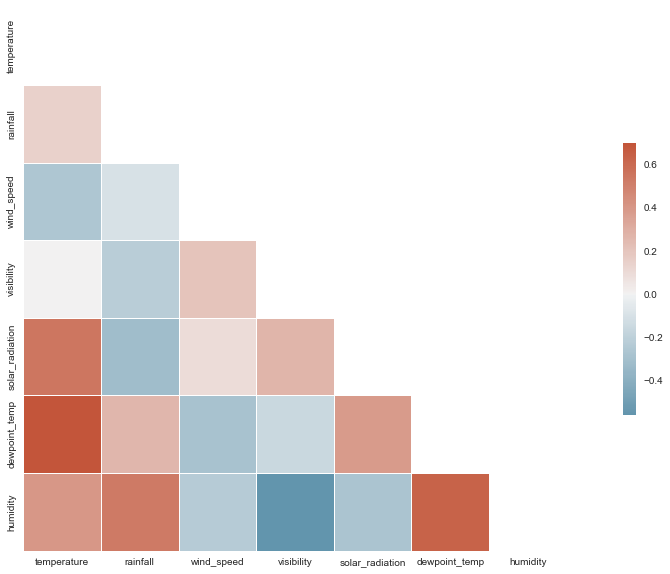

In [340]:
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [341]:
#We will set n_components to 10

N = len(scaled_features.columns)
pca = PCA(n_components=N)
pca.fit(scaled_features)

PCA(n_components=7)

In [342]:
#outputs an array of the variance explained by each component scaled to the total of 1.
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio

array([4.01505555e-01, 2.83597030e-01, 1.31293655e-01, 1.08456825e-01,
       5.59262969e-02, 1.90496058e-02, 1.71033221e-04])

In [343]:
# Cumulative sum of principal components i.e. Cumulative variance of 2 = PC1 variance + PC2 variance
cumulative_variance = np.cumsum(np.round(explained_variance_ratio, decimals=3))
cumulative_variance

array([0.402, 0.686, 0.817, 0.925, 0.981, 1.   , 1.   ])

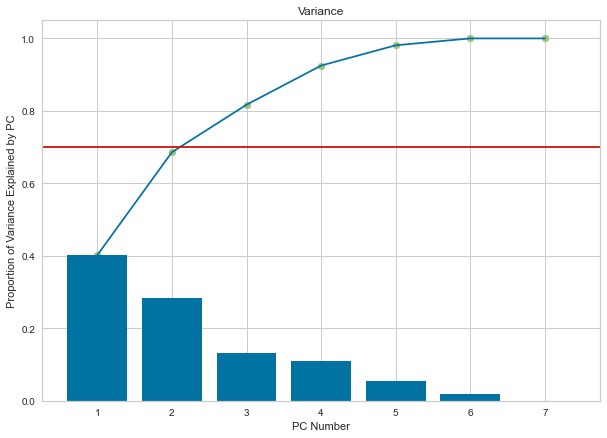

In [344]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance_ratio)
plt.scatter(range(1,N+1),cumulative_variance)
plt.plot(x,cumulative_variance)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color = 'r')

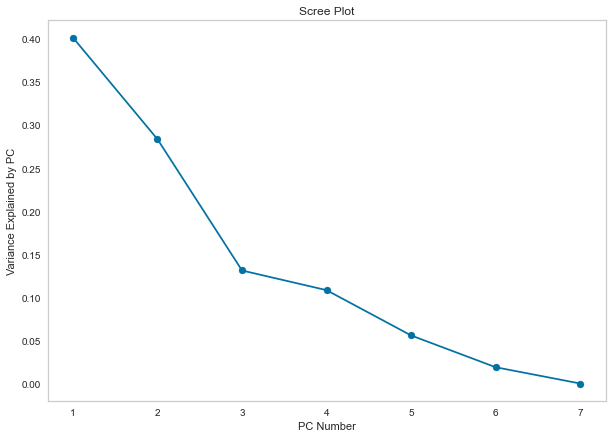

In [345]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),pca.explained_variance_ratio_)
plt.plot(range(1,N+1),pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [346]:
kl = KneeLocator(range(1, N+1), pca.explained_variance_ratio_, curve="convex", direction="decreasing")

kl.elbow

3

In [325]:
def CronbachAlpha(itemscores): #calculate the CronbachAlpha to see how closely related a set of items are as a group
    itemscores = np.asarray(itemscores)
    itemvars = itemscores.var(axis=0, ddof=1)
    tscores = itemscores.sum(axis=1)
    nitems = itemscores.shape[1]
    return (nitems / (nitems-1)) * (1 - (itemvars.sum() / tscores.var(ddof=1)))

In [329]:
pca_label, df_pca_array =evaluate_pcs(2,scaled_features[colnames])
pca_label
# from the elbow plot

,PC1,PC2
temperature,0.975694,
rainfall,,0.694918
wind_speed,,
visibility,,-0.709716
solar_radiation,0.691724,-0.578522
dewpoint_temp,0.922664,
humidity,,0.857564


In [330]:
print(CronbachAlpha(scaled_features[['temperature','solar_radiation','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['rainfall','humidity']])) #Reliability of PC2

0.8375002484595583
0.6916497292299699


In [425]:
df_pca = pd.DataFrame(df_pca_array, columns =['PC1','PC2'])
df_pca.head()

,PC1,PC2
0,-1.301121,-0.404578
1,-0.941620,0.226058
2,-0.810660,1.657565
3,-1.388558,-0.400597
4,-1.679410,-0.397721


# Drop visiblility


In [422]:
bike4 = bike3.copy()
bike4.drop(columns = ['visibility'], inplace = True)
bike4.head()

,temperature,rainfall,wind_speed,solar_radiation,dewpoint_temp,humidity
0,-2.454167,0.0,1.537500,0.248750,-13.545833,45.875000
1,1.325000,0.0,1.712500,0.263750,-5.716667,61.958333
2,4.875000,4.0,1.612500,0.125417,1.883333,81.541667
3,-0.304167,0.1,3.450000,0.282917,-9.925000,52.500000
4,-4.458333,0.0,1.108333,0.035833,-17.425000,36.416667


In [349]:
_ , p_value = calculate_bartlett_sphericity(bike4)
p_value

0.0

In [363]:
_, kmo_score = calculate_kmo(bike4)
kmo_score 

0.4424333187529832

In [352]:

colnames2 = list(bike4.columns)
scaled_features2 = pd.DataFrame(scaler.fit_transform(bike4))

scaled_features2.columns = colnames2

In [423]:
scaled_features2.head()

,temperature,rainfall,wind_speed,solar_radiation,dewpoint_temp,humidity
0,-1.301512,-0.303735,-0.316294,-1.010469,-1.348797,-0.828005
1,-0.978555,-0.303735,-0.022883,-0.962952,-0.745371,0.255453
2,-0.675183,0.036021,-0.190546,-1.401163,-0.159608,1.574690
3,-1.117779,-0.295241,2.890262,-0.902236,-1.069725,-0.381710
4,-1.472782,-0.303735,-1.035848,-1.684945,-1.647781,-1.465168


In [365]:
df_wo_vis = scaled_features.drop(columns = ['visibility'])
N = len(df_wo_vis.columns)
model3 = PCA(n_components = N)
model3.fit(df_wo_vis)
explained_variance3 = model3.explained_variance_ratio_ #Explained Variance Ratio

explained_variance3

array([4.51690905e-01, 2.88927060e-01, 1.51101600e-01, 7.94653028e-02,
       2.86076895e-02, 2.07442561e-04])

In [366]:
cumulative_variance3 = np.cumsum(np.round(explained_variance3, decimals=3))

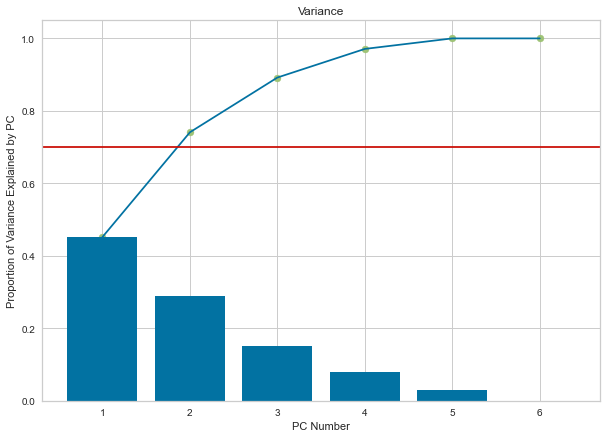

In [367]:
x = list(range(1,N+1))
plt.figure(figsize=(10, 7)) 
plt.bar(x,explained_variance3)
plt.scatter(range(1,N+1),cumulative_variance3)
plt.plot(x,cumulative_variance3)
plt.title('Variance')
plt.xlabel('PC Number')
plt.ylabel('Proportion of Variance Explained by PC')
plt.axhline(y=0.7, color='r')

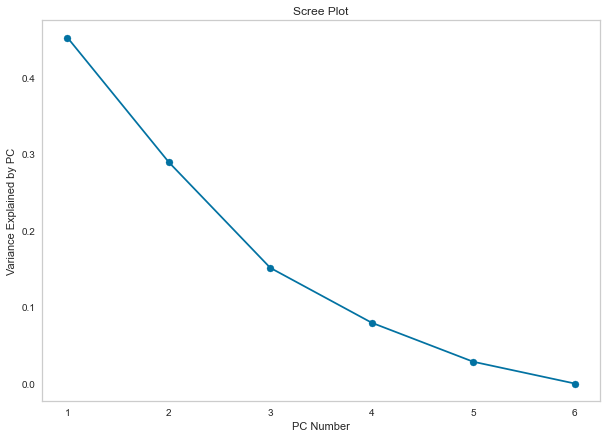

In [368]:
#Scree Plot 
plt.figure(figsize=(10, 7)) 
plt.scatter(range(1,N+1),explained_variance3)
plt.plot(range(1,N+1),explained_variance3)
plt.title('Scree Plot')
plt.xlabel('PC Number')
plt.ylabel('Variance Explained by PC')
plt.grid()

In [369]:
kl2 = KneeLocator(range(1, N+1), model3.explained_variance_ratio_, curve="convex", direction="decreasing")
kl2.elbow

3

In [427]:
pca_label2, df_pca_array2 = evaluate_pcs(2,df_wo_vis)
pca_label2

,PC1,PC2
temperature,0.947466,
rainfall,,0.792289
wind_speed,,
solar_radiation,0.767545,-0.529006
dewpoint_temp,0.872468,
humidity,,0.862505


In [428]:
# 2 PCs
print(CronbachAlpha(scaled_features2[['temperature','solar_radiation','dewpoint_temp']])) #Reliability of PC2
print(CronbachAlpha(scaled_features2[['rainfall','humidity']])) #Reliability of PC1
#print(CronbachAlpha(scaled_features[['temperature','solar_radiation']])) #Reliability of PC2

0.8375002484595583
0.6916497292299699


In [429]:
df_pca2 = pd.DataFrame(df_pca_array2, columns =['PC1','PC2'])
df_pca2.head()

,PC1,PC2
0,-1.339778,-0.295553
1,-0.979877,0.175725
2,-0.833352,1.126314
3,-1.293541,-0.674020
4,-1.750043,-0.245098


# 3rd run without Solar_Radiation

In [378]:
df_wo_vis_sol = df_wo_vis.drop(columns = ['solar_radiation'])
N = len(df_wo_vis_sol.columns)
model4 = PCA(n_components = N)
model4.fit(df_wo_vis_sol)
explained_variance4 = model4.explained_variance_ratio_ #Explained Variance Ratio
cumulative_variance4 = np.cumsum(np.round(explained_variance4, decimals=3))


In [380]:
kl3 = KneeLocator(range(1, N+1), model4.explained_variance_ratio_, curve="convex", direction="decreasing")
pca_label3, df_pca_array3 = evaluate_pcs(kl3.elbow,df_wo_vis_sol)
pca_label3

,PC1,PC2
temperature,0.947018,
rainfall,,0.931555
wind_speed,,
dewpoint_temp,0.933796,
humidity,,0.75605


In [381]:
print(CronbachAlpha(scaled_features[['temperature','dewpoint_temp']])) #Reliability of PC1
print(CronbachAlpha(scaled_features[['rainfall','humidity']])) #Reliability of PC2

0.9810455389386472
0.6916497292299699



# 4th Run: Restart and drop dewpoint_temp

In [386]:
bike5 = bike.copy()
bike5.drop(columns = ['date','holiday','rent_count','season_no','season','snowfall','dewpoint_temp'
                          ],inplace=True)
bike5.head()

,Unnamed: 0,temperature,rainfall,wind_speed,visibility,solar_radiation,humidity
0,1,-2.454167,0.0,1.537500,18707.500000,0.248750,45.875000
1,2,1.325000,0.0,1.712500,14710.833333,0.263750,61.958333
2,3,4.875000,4.0,1.612500,4557.500000,0.125417,81.541667
3,4,-0.304167,0.1,3.450000,13628.333333,0.282917,52.500000
4,5,-4.458333,0.0,1.108333,19594.583333,0.035833,36.416667


In [387]:
bike_wo_dp = bike5.iloc[: , 1:]
bike_wo_dp.head()

,temperature,rainfall,wind_speed,visibility,solar_radiation,humidity
0,-2.454167,0.0,1.537500,18707.500000,0.248750,45.875000
1,1.325000,0.0,1.712500,14710.833333,0.263750,61.958333
2,4.875000,4.0,1.612500,4557.500000,0.125417,81.541667
3,-0.304167,0.1,3.450000,13628.333333,0.282917,52.500000
4,-4.458333,0.0,1.108333,19594.583333,0.035833,36.416667


In [390]:
_ , p_value = calculate_bartlett_sphericity(bike_wo_dp)
p_value

8.37345795545041e-155

In [391]:
_, kmo_score = calculate_kmo(bike_wo_dp)
kmo_score 

0.41639806462383744

In [416]:
colnames = list(bike_wo_dp.columns)

scaled_features3 = pd.DataFrame(scaler.fit_transform(bike_wo_dp))

scaled_features3.columns = colnames

<AxesSubplot:>

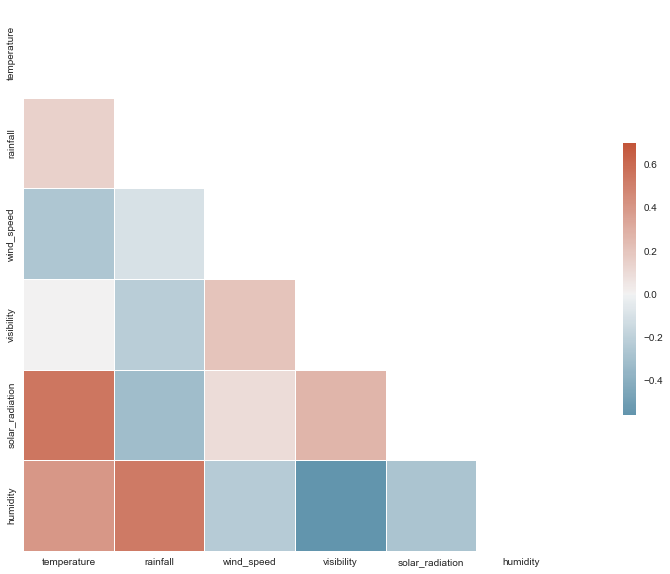

In [417]:
corr = scaled_features3.corr()
plt.subplots(figsize=(20, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap,vmax =0.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [418]:
N = len(scaled_features3.columns)
model5 = PCA(n_components = N)
model5.fit(scaled_features3)
explained_variance5 = model5.explained_variance_ratio_ #Explained Variance Ratio
cumulative_variance5 = np.cumsum(np.round(explained_variance5, decimals=3))

kl4 = KneeLocator(range(1, N+1), model5.explained_variance_ratio_, curve="convex", direction="decreasing")
kl4.elbow

3

In [402]:
pca_label4, df_pca_array4 = evaluate_pcs(2,scaled_features3)
pca_label4

,PC1,PC2
temperature,,0.912968
rainfall,0.692225,
wind_speed,,
visibility,-0.697308,
solar_radiation,,0.81629
humidity,0.893664,


In [410]:
print(CronbachAlpha(scaled_features3[['rainfall','humidity']])) #Reliability of PC2
print(CronbachAlpha(scaled_features3[['temperature','solar_radiation']])) #Reliability of PC1

0.6916497292299699
0.7099057250009291


In [420]:
df2_wo_vis = scaled_features.drop(columns = ['visibility','dewpoint_temp'])
N = len(df2_wo_vis.columns)
model6 = PCA(n_components = N)
model6.fit(df2_wo_vis)
explained_variance6 = model6.explained_variance_ratio_ #Explained Variance Ratio
cumulative_variance6 = np.cumsum(np.round(explained_variance6, decimals=3))
pca_label6, df_pca_array6 = evaluate_pcs(2,df2_wo_vis)
pca_label6


,PC1,PC2
temperature,,0.843552
rainfall,0.762882,
wind_speed,,
solar_radiation,,0.887205
humidity,0.878788,


In [421]:
print(CronbachAlpha(scaled_features[['rainfall','humidity']])) #Reliability of PC2
print(CronbachAlpha(scaled_features[['temperature','solar_radiation']])) #Reliability of PC1

0.6916497292299699
0.7099057250009291
